In [2]:
#Pre-Processing

import os
import argparse
import networkx as nx
import math        
import numpy as np

def state_to_numpy(state):
    strlist = state.split()
    val_list = [float(s) for s in strlist]
    return np.array(val_list)

def list_all_dir(data_dir):
    task_dirs = os.listdir(data_dir)

    list_dir = []
    for task_dir in task_dirs:
        env_dirs = os.listdir(data_dir+"/"+task_dir)
        for env_dir in env_dirs:
            list_dir.append(data_dir +"/"+ task_dir +"/"+ env_dir)
    return list_dir  

def process_it(G, directory):
    start = np.loadtxt(directory+"/start_nodes.txt")
    goal = np.loadtxt(directory+"/goal_nodes.txt")
    occ_grid = np.loadtxt(directory+"/occ_grid.txt")
    # occ_grid = occ_grid.split(",")
    path_nodes = []
    i = 0
    all_data = []
    with open(directory + "/path_nodes.txt", 'r') as file:
        lines  = file.readlines()
        for line in lines:
            line = line.strip('\n')
#             print(line)
#             print("\n\n")
            
            s = state_to_numpy(G.node[str(int(start[i]))]['state'])
            g = state_to_numpy(G.node[str(int(goal[i]))]['state'])
            og = occ_grid[i]
            path_nodes = str(line).split(",")
            # print(path_nodes)
            for path_node in path_nodes:
                if(path_node=='-1'):
                    continue
                node_conf = state_to_numpy(G.node[path_node]['state'])
                curr_node = np.array([])
                # print("Data = ",node_conf, s, g, occ_grid)
#                     print("\n")
#                     print("node_conf = ", node_conf, " s = ", s, " g = ",g)

                curr_node = np.concatenate((node_conf, s, g, og))
#                     print("shape of curr_node = ", curr_node.shape)
                all_data.append(curr_node)
            i+=1
    return all_data

In [4]:
# Workspace problem with several narrow gaps

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random, seed
import time

# (restrict tensorflow memory growth)
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

# neural network parameters
mb_size = 256
h_Q_dim = 512
h_P_dim = 512

c = 0
# learning rate
lr = 1e-4

# problem dimensions
dim = 2
dataElements = dim*3 + 100 # sample (2D), init(2D), goal(2D), occup_grid(400) 

z_dim = 2 # latent
X_dim = dim # samples
y_dim = dim # reconstruction of the original point
c_dim = dataElements - dim # dimension of conditioning variable

In [7]:
G = nx.read_graphml("graphs/dense_graph.graphml")
data_dir = "dataset_23June"

directory = data_dir
print(directory)
final_data = []
flag = 0

data = np.array(process_it(G, directory))

np.random.shuffle(data)
print("shape of array: ",data.shape)

numEntries = data.shape[0]

dataset_23June
('shape of array: ', (44722, 106))


In [9]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

X_train = data[0:numTrain,0:dim] # state: x, y, z, xdot, ydot, zdot
c_train = data[0:numTrain,dim:dataElements] # conditions: gaps, init (6), goal (6)
# print("c_train = ",c_train[:,:4])

X_test = data[numTrain:numEntries,0:dim]
c_test = data[numTrain:numEntries,dim:dataElements]

#########################################################
c_train1 = []
c_test1 = []
c_train1 = c_train
c_test1 = c_test
#########################################################
numTest = X_test.shape[0]
# print(data[:,:6])
# print(c_test[:,:4])

# print("shape of final obstacle = ",obs.shape)
print("shape of c_train1 = ", c_train1.shape)
print("shape of c_test1 = ",c_test1.shape)

('shape of c_train1 = ', (35777, 104))
('shape of c_test1 = ', (8945, 104))


In [117]:
# define networks
print("X_dim = ",X_dim)
print("c_dim = ",c_dim)
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, c_dim])
    
# Q
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P
eps = tf.random_normal(shape=tf.shape(z_mu))
z = z_mu + tf.exp(z_logvar / 2) * eps
inputs_P = tf.concat(axis=1, values=[z,c])

dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=X_dim) # fix to also output y

# training
########### comment in the one with 0 weight and uncomment the other ###########
w = [[1, 1]];
# w = [[1, 1, 1, 0, 0, 0]];
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=w)

# TODO: fix loss function for angles going around
kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
it = 0;

('X_dim = ', 2)
('c_dim = ', 104)


In [119]:
saver = tf.train.Saver()
path_ = os.getcwd() + "/checkpoints_NS/model.ckpt"
print("path = ",path_)
print("numTrain = ",numTrain)
try:
    saver.restore(sess, path_)
    print("Model Restored!!")
except Exception as e:
    print("Could not restore checkpoint!")
    print(e)
x1 = []
y1 = []    
print("z_dim = ", z_dim)
print("c_dim = ", c_dim)
print("c_train = ", c_train.shape)
for it in range(it,it+600001):
#     print("c_dim = ",c_dim)
    # randomly generate batches
    batch_elements = [randint(0,numTrain-1) for n in range(0,mb_size)]
    X_mb = X_train[batch_elements,:]
    c_mb = c_train1[batch_elements,:]

    _, loss, r = sess.run([train_step, cvae_loss, recon_loss], feed_dict={X: X_mb, c: c_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        x1.append(it)
        y1.append(loss)
        print("recon_loss = ", r)
    if it % 1000 == 0:    
        saver.save(sess, path_)
        print("saved session to ", path_)

('path = ', '/home/vernwalrahul/projects/Workspace_RF_2d/checkpoints_NS/model.ckpt')
('numTrain = ', 35777)
INFO:tensorflow:Restoring parameters from /home/vernwalrahul/projects/Workspace_RF_2d/checkpoints_NS/model.ckpt
Model Restored!!
('z_dim = ', 2)
('c_dim = ', 104)
('c_train = ', (35777, 104))
Iter: 1000
Loss: 0.001339
('recon_loss = ', 0.00034508196)
('saved session to ', '/home/vernwalrahul/projects/Workspace_RF_2d/checkpoints_NS/model.ckpt')


KeyboardInterrupt: 

In [ ]:
#to check if a node is free
def is_free(node_pos, obstacles):
    flag = 1
    eps = 0.04
    for obs in obstacles:
        x1, y1, x2, y2 = obs
        if(node_pos[0] < x2 + eps and node_pos[0] > x1 - eps):
            if(node_pos[1] < y2 + eps and node_pos[1] > y1 - eps):
                flag = 0
                return flag
    return flag

################Create Occ_Grid
def get_occ_grid(obstacles):
    occ_grid = np.ones((10,10), dtype=int)
    eps = 0.05
    for i in range(0,10):
        for j in range(0, 10):
            if(not (is_free((i/10.0+eps,j/10.0+eps), obstacles))):
                occ_grid[i,j] = 0
            else:
                occ_grid[i,j] = 1
    return occ_grid.ravel()

obs1 = [0.0, 0.1, 0.4, 0.2]
obs2 = [0.5, 0.1, 0.6, 0.2]
obs3 = [0.7, 0.1, 1.0, 0.2]

init_ = np.array([0.05 , 0.95])
goal_ = np.array([0.95 , 0.95])

c_here = []
for x in range(1,7):
    obs4 = [x/10.0, 0.5, x/10.0+0.1, 1.0]
    obs5 = [x/10.0, 0.2, x/10.0+0.1, 0.4]
    obs6 = [x/10.0, 0.0, x/10.0+0.1, 0.1]
    
    obstacles = [obs1, obs2, obs3, obs4, obs5, obs6]
    curr_occ_grid = np.array(get_occ_grid(obstacles))
    print(curr_occ_grid.reshape(10,10))
    c_here.append(np.concatenate((init_, goal_, curr_occ_grid)))

('c_test.shape = ', (8945, 104))
('c_train.shape = ', (35777, 104))
7704
[0.01653381 0.34530272 0.43792053 0.11713628 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 1.         1.         0.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.         1.         1.         1.
 1.         1.         1.         1.      

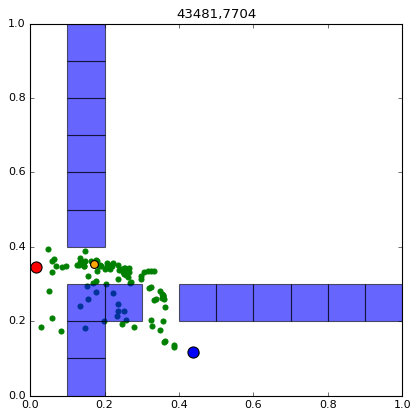

In [24]:
# plot the latent space
num_viz = 100
# seed(1000)
print("c_test.shape = ",c_test.shape)
print("c_train.shape = ",c_train.shape)
# print(c_test[:,:4])
# seed(100)
vizIdx = randint(0,numTest-1);
# vizIdx = 2180
print vizIdx
c_sample_seed = data[numTrain+vizIdx,2:]
print(c_sample_seed)
print("c_sample_seed = ", c_sample_seed[:4])
occ_g = c_sample_seed[4:].reshape(10,10)

# c_here = np.array(c_here)
# c_sample_seed = c_here[0,:]
# occ_g = c_here[0,4:].reshape(10,10)

ts = X_test[vizIdx,:2]
print("Train Sample = ", ts)

# c_sample_seed = c_test[vizIdx,:]
# occ_g = c_test[vizIdx,4:].reshape(20,20)
# print("Testing Sample = ",X_test[vizIdx,:2])

# print(c_sample_seed[:4])
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]
c_sample = np.repeat([c_sample_seed],num_viz,axis=0)

print("c_sample.shape = ",c_sample.shape)
# directly sample from the latent space (preferred, what we will use in the end)
y_viz, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')

plt.scatter(y_viz[:,0],y_viz[:,1], color="green", s=20)
plt.title(str(numTrain+vizIdx)+","+str(vizIdx))

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.scatter(init[0], init[1], color="red", s=100, edgecolors='black') # init
plt.scatter(goal[0], goal[1], color="blue", s=100, edgecolors='black') # goal
plt.scatter(ts[0], ts[1], color="orange", s=50, edgecolors='black') # goal

plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig("testing_"+str(numTrain+vizIdx)+".jpg", bbox_inches='tight')
plt.show()

In [239]:
# conditions = []
# t_cases = [33396, 37596, 37206, 37214, 35591, 32447, 33265, 34226, 31937, 38062, 37070, 34959, 34088, 36841, 31974, 35897, 38648, 32513, 38753, 37170]
# print(data[3396,2:])
# for t in t_cases:
#     conditions.append(data[t,2:])
# # print(conditions)
# print(len(conditions))
# print(conditions[0])
# conditions = np.array(conditions)
# print(conditions.shape)
# np.savetxt("test_cases.txt", conditions, delimiter = " ", fmt = "%s")

def load_conditions(directory):
    start_posns = np.loadtxt(directory+"/start_posns.txt", delimiter=" ")
    goal_posns = np.loadtxt(directory+"/goal_posns.txt", delimiter=" ")
    occ_grid = np.loadtxt(directory+"/occ_grid.txt", delimiter=" ")
    
    cond = np.concatenate((start_posns, goal_posns, occ_grid), axis = 1)
    
    print("cond.shape = ", cond.shape)
    return cond

conditions = load_conditions("test_dataset_23June/easy")

('cond.shape = ', (100, 104))


In [240]:
# conditions = np.loadtxt("test_cases.txt", delimiter = " ")
print(conditions)

[[0.02441759 0.93227395 0.75757127 ... 1.         1.         1.        ]
 [0.26861565 0.70930449 0.7733626  ... 1.         1.         1.        ]
 [0.18471032 0.8201976  0.96368896 ... 1.         1.         1.        ]
 ...
 [0.94582876 0.81263927 0.10186312 ... 1.         1.         1.        ]
 [0.17707145 0.83243238 0.89689576 ... 1.         1.         1.        ]
 [0.20330311 0.45177786 0.35919237 ... 1.         1.         1.        ]]


In [249]:
def state_to_numpy(state):
    strlist = state.split()
#     print("strlist = ", strlist)
    val_list = [float(s) for s in strlist]
    return np.array(val_list)

def edge_to_configs(state1, state2):
    EDGE_DISCRETIZATION = 20
    config1 = state_to_numpy(state1)
    config2 = state_to_numpy(state2)

    diff = config2 - config1
    step = diff/EDGE_DISCRETIZATION

    to_check = list()
    to_check.append(config1)

    for i in xrange(EDGE_DISCRETIZATION - 1):
        conf = config1 + step*(i+1)
        to_check.append(conf)

    return to_check

def display_plot(occ_grid, output_samples, graph_samples, path_samples, init, goal, G1):
    fig1 = plt.figure(figsize=(10,6), dpi=80)
    ax1 = fig1.add_subplot(111, aspect='equal')
    
    for i in range(10):
            for j in range(10):
                if(occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/10.0, j/10.0),   # (x,y)
                    0.1,          # width
                    0.1,          # height
                    alpha=0.6
                    ))
                
    plt.scatter(init[0], init[1], color="red", s=100, edgecolors='black') # init
    plt.scatter(goal[0], goal[1], color="blue", s=100, edgecolors='black') # goal
    
    plt.scatter(output_samples[:,0],output_samples[:,1], color="green", s=20)
    plt.scatter(graph_samples[:,0], graph_samples[:,1], color ="orange", s=20)
    
    if(not path_samples==None):
        path_samples = np.array(path_samples)
        plt.plot(path_samples[:,0], path_samples[:,1], color = "blue")
#     print("in display no of edges = ", len(G1.edges()))
#     for edge in G1.edges():
#         u, v = edge
#         conf1, conf2 = state_to_numpy(G1.node[u]['state']), state_to_numpy(G1.node[v]['state'])
#         l = np.array((conf1, conf2))
# #         print("l.shape = ", l.shape)
# #         print("l = ", l)
#         plt.plot(l[:,0], l[:,1], color = "black")
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title(str(count))
    plt.show()
    

def get_graph_samples(shallow_G, occ_grid):
    samples = []
    for node in shallow_G.nodes():
            eps = 0.035
            cc = state_to_numpy(shallow_G.node[node]['state'])
            x_, y_ = float(cc[0]), float(cc[1])
            
            x_ = min(0.95, cc[0])
            y_ = min(0.95, cc[1])
            if(occ_grid[int((x_+eps)*10), int((y_)*10)]==0 or occ_grid[int((x_-eps)*10), int((y_)*10)]==0 or occ_grid[int((x_)*10), int((y_+eps)*10)]==0 or occ_grid[int((x_)*10), int((y_-eps)*10)]==0):
                continue
            else:
                samples.append(cc)
    
    return np.array(samples)

#get output node posns
def get_o_node_posns(c_sample_seed, num_viz, count):
#     return []
    c_sample = []
    for i in range(num_viz):
        x1 = randint(0, len(c_sample_seed)-1)
        init = c_sample_seed[x1,:2]
        goal = c_sample_seed[x1,2:4]
        occ_grid = c_sample_seed[x1,4:].reshape(10,10)
        c_sample.append(c_sample_seed[x1,:])
    
    c_sample = np.array(c_sample)
    c_sample = np.float64(c_sample)
    print("c_sample.shape = ", c_sample.shape)
#     c_sample = np.random.randn(num_viz, 104)
    y_viz, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})
    
    
    free_nodes = []
    y_viz = np.array(y_viz)
    y_viz = list(y_viz)
#     print("y_viz = ",y_viz)
    for cc in y_viz:
            eps = 0.035
            x_, y_ = float(cc[0]), float(cc[1])
            
            x_ = min(0.95, cc[0])
            y_ = min(0.95, cc[1])
            if(occ_grid[int((x_+eps)*10), int((y_)*10)]==0 or occ_grid[int((x_-eps)*10), int((y_)*10)]==0 or occ_grid[int((x_)*10), int((y_+eps)*10)]==0 or occ_grid[int((x_)*10), int((y_-eps)*10)]==0):
                continue
            else:
                free_nodes.append(cc)
    y_viz = np.array(free_nodes)
    
    return y_viz

#load shallow_graph
def load_halton_samples(num_viz):
    shallow_G = nx.read_graphml("graphs/halton2D"+str(num_viz)+"_1.graphml")
    shallow_G.remove_edges_from(list(shallow_G.edges()))
    return shallow_G

def remove_invalid_edges(G, occ_grid):
    
    # print("total no of edges = ", len(list(G.edges())))
    to_remove = []
    for edge in G.edges():
        u, v = edge
        state1 = G.node[u]['state']
        state2 = G.node[v]['state']
        configs_to_check = edge_to_configs(state1,state2)

        edge_free = 1
        eps = 0.040
        for cc in configs_to_check:
            cc[0] = min(0.95, cc[0])
            cc[1] = min(0.95, cc[1])
            if(occ_grid[int((cc[0]+eps)*10), int((cc[1])*10)]==0 or occ_grid[int((cc[0]-eps)*10), int((cc[1])*10)]==0 or occ_grid[int((cc[0])*10), int((cc[1]+eps)*10)]==0 or occ_grid[int((cc[0])*10), int((cc[1]-eps)*10)]==0):
                edge_free = 0
                break
        if(not edge_free):
            to_remove.append((u, v))

    for r in to_remove:
        G.remove_edge(r[0], r[1])
    
#     print("removed ", len(to_remove), "edges")
        
    return G

In [251]:

def calc_weight(s, g):
    return sqrt(np.sum((s-g)**2))

def connect_within_thresh(G, THRESHOLD, lmbda):
    for node in G.nodes():
        for node1 in G.nodes():
            if(node==node1):
                continue
            else:
                conf1 = state_to_numpy(G.node[node]['state'])
                conf2 = state_to_numpy(G.node[node1]['state'])
                w = calc_weight(conf1, conf2)
                if(w<THRESHOLD*lmbda):
                    G.add_edge(node, node1)
                    G[node][node1]['weight'] = w
    return G

# def connect_knn(G, K):
# #     print("no of nodes = ", len(list(G.nodes())))
#     for node in G.nodes():
#         state = G.node[node]['state']
#         conf = state_to_numpy(state)
#         G1 = G.copy()

#         for k in range(K):
#             w = 1000000
#             sn = None
#             for node1 in G1.nodes():
#             	if(node == node1):
#             		continue
#                 state1 = G1.node[node1]['state']
# #                 print("node1 = ",node1)
# #                 print("state1 = ",state1)
                
#                 conf1  = state_to_numpy(state1)
#                 if(calc_weight(conf, conf1) < w):
#                     w = calc_weight(conf, conf1)
#                     sn = node1

#             # if(check_for_collision(node, sn)==1):
#             G.add_edge(node, sn)
#             # print("connected edge from ",node, " to ",sn)
#             G[node][sn]['weight'] = w
#             G1.remove_node(sn)
#     return G

def get_path_length(graph_samples, o_node_posns, src_posns, goal_posns, occ_grid, THRESHOLD, lmbda):
    
#     print("len(o_node_posns) = ", len(o_node_posns))
    G_here = nx.Graph()
    
    for i in range(len(src_posns)):
        src_posn = src_posns[i]
        goal_posn = goal_posns[i]
        sx, sy = src_posn[0], src_posn[1]
        gx, gy = goal_posn[0], goal_posn[1]
        G_here.add_node('s'+str(i), state = str(sx)+" "+str(sy))
        G_here.add_node('g'+str(i), state = str(gx)+" "+str(gy))
    for i in range(len(o_node_posns)):
        x,y = o_node_posns[i][0], o_node_posns[i][1]
        G_here.add_node('o'+str(i), state = str(x)+" "+str(y))
#     print("connecting within thresh")    
    for i in range(len(graph_samples)):
            x,y = graph_samples[i][0], graph_samples[i][1]
            G_here.add_node('i'+str(i), state = str(x)+" "+str(y))

    G_here = connect_within_thresh(G_here, THRESHOLD, lmbda)
#     print("connected within thresh")
    G_here = G_here.to_undirected()
    G_here = remove_invalid_edges(G_here, occ_grid)
    path_length = None
    path_node_posns = []

    #     print("no of nodes = ", len(G_here.nodes()))
    #     print("no of edges = ", len(G_here.edges()))
    path_lengths = []
    for i in range(len(src_posns)):
        try:
#             print("start = ", G_here.node['s'+str(i)]['state'])
#             print("goal = ", G_here.node['g'+str(i)]['state'])
#             path_nodes = nx.shortest_path(G_here,source='s',target='g')
#             for node in path_nodes:
#                 path_node_posns.append(state_to_numpy(G_here.node[node]['state']))
            path_length = nx.dijkstra_path_length(G_here,'s'+str(i),'g'+str(i), weight = 'weight')
            path_lengths.append(path_length)
        except Exception as e:
            print("Exception= ", e)
            path_lengths.append(-1)
            pass
    #     print("returning path_length = ", path_length, " path_node_posns = ", path_node_posns)
    return path_lengths, G_here

In [ ]:
def get_uniform_samples(num_viz):
    num_viz = int(num_viz)
    return np.random.rand(num_viz,2)

from random import randint
from math import sqrt
# cond_test = []
# test_cases = []
# for x in range(10):
#     test_cases.append(randint(0,numTest-1))

# test_cases = [1379]
s_d=[100, 200, 300]

for sd in s_d: 
    seed(sd)
    num_v = [200, 400, 600, 800, 1000, 1200, 1500, 2000]
    # consid = [25,56,57,58,59,71,72,80,81,82,83,84,90,91,92,93,94]
    THRESHOLD = 0.1
    prop_u = 0.5

    path_length_matrix = np.zeros((len(num_v), len(conditions)), dtype = float)

    for num_viz in num_v:
        print("--------------------------------Num_Viz = ", num_viz)
        lmbda = 1
        print("--------------------------------------lmbda = ",1)
        shallow_G = load_halton_samples(int(num_viz*prop_u))
        path_lengths = []
        all_path_nodes_posns = []
        count = 0
        # print(test_cases)
        # print(conditions[0])
        # return
        failed_c = 0
        path_found = []
        path_lengths = []
        for num in range(0, len(conditions), 5):
            c_sample_seed = conditions[num:num+5,:]
    #         if(not count in consid):
    #             count += 1
    #             continue
        #     print("---------------------------------------cond = ",cond)
    #         if(count<37 or count>37):
    #             count+=1
    #             continue
            print("count = ", count)
            o_node_posns = get_o_node_posns(c_sample_seed, int(num_viz*(1-prop_u)), count)
    #         print("got node posns l = ", len(o_node_posns))
            occ_grid = c_sample_seed[0,4:].reshape(10,10)
            graph_samples = get_graph_samples(shallow_G, occ_grid)

    #         graph_samples = get_uniform_samples(num_viz*prop_u)
            path_lengths, G1 = get_path_length(graph_samples, o_node_posns, c_sample_seed[:,:2], c_sample_seed[:,2:4], occ_grid, THRESHOLD, lmbda)

            #     path_lengths.append(path_length)
            for p in range(len(path_lengths)):
                path_length = path_lengths[p]
                if(path_length==None):
                    failed_c += 1
                    path_found.append(0)
                    path_length_matrix[num_v.index(num_viz), num+p] = -1
                else:
                    path_found.append(1)
                    path_length_matrix[num_v.index(num_viz), num+p] = path_length
            print("count = ", count," path_lengths = ", path_lengths)
    #         print("path_node_posns = ", path_node_posns)

    #         display_plot(occ_grid, o_node_posns, graph_samples, path_node_posns, cond[:2], cond[2:4], G1)
    #         try:
    #             nx.dijsktra_path(G1, 's', 'g', )
            all_path_nodes_posns.append(path_node_posns)
            count += 5
        print(path_lengths)
    #     assert failed_c==0
        print(failed_c)
        print("failed = ", failed_c)
        print("path_lengths = ", path_lengths)
    direct = "/home/vernwalrahul/projects/Workspace_RF_2d/test_dataset_23June/"
    np.savetxt(direct+"easy/p5/RF_m_"+str(s_d.index(sd)+1)+"_pl_matrix_lmbda"+str(lmbda)+".txt", path_length_matrix)

('--------------------------------Num_Viz = ', 200)
('--------------------------------------lmbda = ', 1)
('count = ', 0)
('c_sample.shape = ', (100, 104))
('Exception= ', NetworkXNoPath('Node g0 not reachable from s0',))
('Exception= ', NetworkXNoPath('Node g1 not reachable from s1',))
('Exception= ', NetworkXNoPath('Node g2 not reachable from s2',))
('Exception= ', NetworkXNoPath('Node g3 not reachable from s3',))
('Exception= ', NetworkXNoPath('Node g4 not reachable from s4',))
('count = ', 0, ' path_lengths = ', [-1, -1, -1, -1, -1])
('count = ', 5)
('c_sample.shape = ', (100, 104))
('Exception= ', NetworkXNoPath('Node g2 not reachable from s2',))
('Exception= ', NetworkXNoPath('Node g3 not reachable from s3',))
('count = ', 5, ' path_lengths = ', [0.3268558721108007, 1.0704014993315845, -1, -1, 0.7019461000819016])
('count = ', 10)
('c_sample.shape = ', (100, 104))
('Exception= ', NetworkXNoPath('Node g0 not reachable from s0',))
('Exception= ', NetworkXNoPath('Node g1 not reachab

('count = ', 0, ' path_lengths = ', [1.7925431907128913, 1.2140740451494616, 1.5831539908522456, 1.3615478231332123, 1.3849606830563606])
('count = ', 5)
('c_sample.shape = ', (200, 104))
('count = ', 5, ' path_lengths = ', [0.3222862578411877, 1.0223374958675637, 0.7343451512098228, 0.7280309290285062, 0.5293156001603702])
('count = ', 10)
('c_sample.shape = ', (200, 104))
('count = ', 10, ' path_lengths = ', [1.5439962698805296, 1.5126828133141865, 1.3930485161854844, 1.7719161185091117, 1.1954968479961805])
('count = ', 15)
('c_sample.shape = ', (200, 104))
('Exception= ', NetworkXNoPath('Node g0 not reachable from s0',))
('Exception= ', NetworkXNoPath('Node g1 not reachable from s1',))
('Exception= ', NetworkXNoPath('Node g2 not reachable from s2',))
('count = ', 15, ' path_lengths = ', [-1, -1, -1, 0.7381508433734119, 1.1015217457245612])
('count = ', 20)
('c_sample.shape = ', (200, 104))
('Exception= ', NetworkXNoPath('Node g1 not reachable from s1',))
('Exception= ', NetworkXNoP

('count = ', 75, ' path_lengths = ', [0.4412237538473441, 0.8113124246374644, 0.6244735012596834, 0.5566510445163, 0.47539061555668627])
('count = ', 80)
('c_sample.shape = ', (300, 104))
('count = ', 80, ' path_lengths = ', [0.9439955418644099, 0.47965910777549936, 0.5732232750029966, 1.1138233346466924, 0.5806912383392914])
('count = ', 85)
('c_sample.shape = ', (300, 104))
('count = ', 85, ' path_lengths = ', [0.9304708376098485, 1.0459113273764276, 0.8399436306434782, 0.8082541436126233, 0.8074008356127322])
('count = ', 90)
('c_sample.shape = ', (300, 104))
('count = ', 90, ' path_lengths = ', [0.6539342598973794, 0.4171437184150074, 0.9699141658846112, 0.5832966011818668, 0.37180855812471886])
('count = ', 95)
('c_sample.shape = ', (300, 104))
('count = ', 95, ' path_lengths = ', [0.5231369661095902, 0.8228629321706631, 0.8736407469363152, 0.9021789854823999, 0.35561204630925103])
[0.5231369661095902, 0.8228629321706631, 0.8736407469363152, 0.9021789854823999, 0.35561204630925103

('count = ', 50, ' path_lengths = ', [0.6272380600275848, 1.1638906682383987, 0.7959539762913788, 0.4481778110812353, 1.1105593832221337])
('count = ', 55)
('c_sample.shape = ', (500, 104))
('count = ', 55, ' path_lengths = ', [0.834217967515515, 0.6512705268267613, 0.699755385734878, 0.7958221869941716, 0.7919353986355622])
('count = ', 60)
('c_sample.shape = ', (500, 104))
('Exception= ', NetworkXNoPath('Node g0 not reachable from s0',))
('Exception= ', NetworkXNoPath('Node g2 not reachable from s2',))
('Exception= ', NetworkXNoPath('Node g4 not reachable from s4',))
('count = ', 60, ' path_lengths = ', [-1, 0.5949500066741902, -1, 0.5920162815193485, -1])
('count = ', 65)
('c_sample.shape = ', (500, 104))
('count = ', 65, ' path_lengths = ', [1.2306308856729837, 0.9678219843535008, 1.3774328289115274, 1.0130911298287735, 0.666580148917683])
('count = ', 70)
('c_sample.shape = ', (500, 104))
('count = ', 70, ' path_lengths = ', [0.7895091423248828, 0.8425602032650633, 1.1249593109197

('count = ', 40, ' path_lengths = ', [0.6343414250183366, 0.9522484106574344, 0.6200660730969255, 0.9417508519231669, 0.8260660880047692])
('count = ', 45)
('c_sample.shape = ', (750, 104))
('count = ', 45, ' path_lengths = ', [0.8173421063074322, 0.8819810810475642, 0.8627670269368687, 0.6251909689034771, 0.8973623986230201])
('count = ', 50)
('c_sample.shape = ', (750, 104))
('count = ', 50, ' path_lengths = ', [0.6253939949683576, 1.1682280242885916, 0.7850168702327154, 0.4477490225306532, 1.1083369171810311])
('count = ', 55)
('c_sample.shape = ', (750, 104))
('count = ', 55, ' path_lengths = ', [0.8275427738897793, 0.637797295670511, 0.672109787547177, 0.7710748086591794, 0.7908945905822644])
('count = ', 60)
('c_sample.shape = ', (750, 104))
('Exception= ', NetworkXNoPath('Node g0 not reachable from s0',))
('Exception= ', NetworkXNoPath('Node g2 not reachable from s2',))
('Exception= ', NetworkXNoPath('Node g4 not reachable from s4',))
('count = ', 60, ' path_lengths = ', [-1, 0.

[0.38225646 0.07689851 0.15911193 0.81855375 1.         1.
 1.         1.         1.         0.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.         1.         1.         1.         1.
 1.         1.         1.         1.         0.         1.
 1.         1.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         1.         1.         1.         1.
 1.         0.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.         1.         

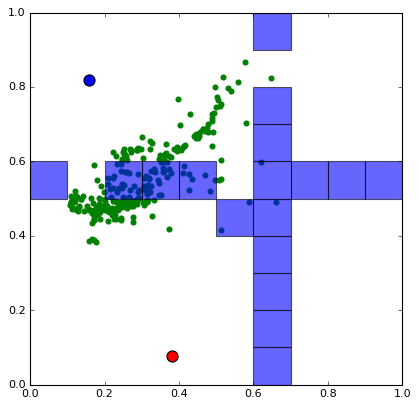

In [216]:
num_viz = 300
c_sample_seed1 = [0.38225646, 0.07689851, 0.15911193, 0.81855375, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 1.        ]

c_sample_seed1 = np.array(c_sample_seed1)

c_sample_seed1[4+14] = 1
c_sample_seed1[4+54] = 0

print(c_sample_seed1)
print("c_sample_seed = ", c_sample_seed1[:4])
occ_g = c_sample_seed1[4:].reshape(10,10)

# c_here = np.array(c_here)
# c_sample_seed = c_here[0,:]
# occ_g = c_here[0,4:].reshape(10,10)

ts = X_test[vizIdx,:2]
print("Train Sample = ", ts)

# c_sample_seed = c_test[vizIdx,:]
# occ_g = c_test[vizIdx,4:].reshape(20,20)
# print("Testing Sample = ",X_test[vizIdx,:2])

# print(c_sample_seed[:4])
init = c_sample_seed1[:2]
goal = c_sample_seed1[2:4]
c_sample = np.repeat([c_sample_seed1],num_viz,axis=0)

print("c_sample.shape = ",c_sample.shape)
# directly sample from the latent space (preferred, what we will use in the end)
y_viz, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')

plt.scatter(y_viz[:,0],y_viz[:,1], color="green", s=20)
# plt.title(str(numTrain+vizIdx)+","+str(vizIdx))

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.scatter(init[0], init[1], color="red", s=100, edgecolors='black') # init
plt.scatter(goal[0], goal[1], color="blue", s=100, edgecolors='black') # goal
# plt.scatter(ts[0], ts[1], color="orange", s=50, edgecolors='black') # goal

plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig("test_samples/rf_pattern3.jpg", bbox_inches='tight')
plt.show()

In [96]:
print("failed = ", failed_c)
print("path_lengths = ", path_lengths)
np.savetxt("test_dataset_23June/medium/path_lengths_RF_numviz"+str(num_viz)+"_k"+str(k)+".txt", path_lengths)

('failed = ', 18)
('path_lengths = ', [1.2907752859418187, 1.2966528893878486, -1, 0.992470229100583, 1.0042319452526127, 1.5592796048014395, 1.3293697366330455, -1, 1.4088315713851587, 1.347439562889939, -1, -1, 1.2083699929529883, 1.6233808231962277, 1.8201370303169067, 1.1410629342459466, 1.174797669181548, 1.6143317084125954, 1.5045632761392058, 1.1706578425659133, -1, -1, 1.0412291480989797, 1.1648855804721152, -1, 1.2635972117483234, 1.26478474951186, 1.2921663965522314, 1.0769564621699608, 1.6432431435457266, 1.0221766367539902, 1.1718769475619881, 1.3508734565623586, 0.79813465993683, 1.2019123568636683, 1.5653675487051668, 0.897416078020395, 1.0197186777755156, 0.7904341202702472, 1.494097656848409, 1.5329778890117733, 1.0140402082837932, 0.8184911432386902, 0.9946987190775264, 1.0900865571134761, 1.1345132577730914, 1.2748972142489414, -1, -1, 1.4082925256140124, -1, 0.8915700688642758, -1, 0.7558044504179019, 1.075913448228969, 0.7685595430849566, 1.1009305879201632, 1.19328

In [53]:
print(test_cases)
print(numTrain+4396)
print(c_test[4396,:4])
print(data[numTrain+4396,2:6])

[351, 300, 3355, 1546, 281, 2124, 2449, 36, 5276, 2299, 4396]
36274
[0.06047912 0.41480432 0.94036193 0.26299819]
[0.06047912 0.41480432 0.94036193 0.26299819]


In [71]:
for i in range(len(test_cases)):
    cond = c_test[test_cases[i],:]
    occ_grid = cond[4:].reshape(10,10)
    node_posns = np.array(all_path_nodes_posns[i])
    init = cond[:2]
    goal = cond[2:4]
    
    fig1 = plt.figure(figsize=(10,6), dpi=80)
    ax1 = fig1.add_subplot(111, aspect='equal')
    
    plt.scatter(node_posns[:,0], node_posns[:,1], color="green", s=20)
    
    for i in range(10):
            for j in range(10):
                if(occ_g[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/10.0, j/10.0),   # (x,y)
                    0.1,          # width
                    0.1,          # height
                    alpha=0.6
                    ))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.scatter(init[0], init[1], color="red", s=100, edgecolors='black') # init
    plt.scatter(goal[0], goal[1], color="blue", s=100, edgecolors='black') # goal
    plt.show()